# Retrieve Observed Snow Data 

Last updated: 06/23/2024

## Introduction

This notebook outlines the steps to visualize the boundaries of the study watershed and identify the SNOTEL stations within the study basin. The Snow Water Equivalent (SWE) data from these SNOTEL stations are then retrieved from the USDA-NRCS website.

**Note**: The dataset for the selected basin is subsetted using the [v20.1 hydrofabric](https://www.lynker-spatial.com/data?path=hydrofabric%2Fv20.1%2F) and [NWM retrospective v3 forcing](https://noaa-nwm-retrospective-3-0-pds.s3.amazonaws.com/index.html#CONUS/zarr/forcing/) data. More information can be found in this [GitHub repository](https://github.com/CIROH-UA/NGIAB_data_preprocess).

Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import folium
import os
import requests
from datetime import datetime

### Create geodataframe for the selected basin

In [2]:
gdf_catchment = gpd.read_file('catchments.geojson')

In [4]:
# Print the current CRS of the GeoDataFrame
print("Current CRS:", gdf_catchment.crs)

# Reproject the GeoDataFrame to WGS84 (EPSG:4326)
gdf_catchment = gdf_catchment.to_crs(epsg=4326)

# Print the new CRS to confirm the change
print("New CRS:", gdf_catchment.crs)

Current CRS: EPSG:4326
New CRS: EPSG:4326


### Identify SNOTEL stations within watershed

In [7]:
#Reading CSV file of the SNOTEL sites
SNT= pd.read_csv('Snotel-CDEC-SnowObs(2).csv')

In [8]:
#Define the boundaries for the basin
bounds = gdf_catchment.bounds

min_longitude = bounds.minx.min()
max_longitude = bounds.maxx.max()
min_latitude = bounds.miny.min()
max_latitude = bounds.maxy.max()

In [10]:
# Filter the DataFrame based on the specified range for column1 and column2
filtered_SNT = SNT[(SNT['latitude'] >= min_latitude) & (SNT['latitude'] <= max_latitude) &
                 (SNT['longitude'] >= min_longitude) & (SNT['longitude'] <= max_longitude)]

In [13]:
#Creating geodataframe file for the filtered SNOTEL sites
SnowTel = gpd.GeoDataFrame(
    filtered_SNT, geometry=gpd.points_from_xy(filtered_SNT['longitude'], filtered_SNT['latitude'])
)

In [14]:
# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
SnowTel.set_crs(epsg=4326, inplace=True)

,station_id,name,elevation_m,latitude,longitude,state,geometry
4,CDEC:BCH,Beach Meadows,2331.72,36.126095,-118.293457,California,POINT (-118.29346 36.12609)
19,CDEC:CHP,Chagoopa Plateau,3139.44,36.497143,-118.446716,California,POINT (-118.44672 36.49714)
22,CDEC:CSV,Casa Vieja Meadows,2529.84,36.198097,-118.267685,California,POINT (-118.26769 36.19810)
35,CDEC:FRW,Farewell Gap,2895.60,36.415211,-118.578979,California,POINT (-118.57898 36.41521)
70,CDEC:PSC,Pascoes,2788.92,35.966999,-118.349998,California,POINT (-118.35000 35.96700)
72,CDEC:QUA,Quaking Aspen,2194.56,36.117508,-118.539993,California,POINT (-118.53999 36.11751)
98,CDEC:UTY,Upper Tyndall Creek,3474.72,36.650002,-118.397003,California,POINT (-118.39700 36.65000)
104,CDEC:WTM,Wet Meadows,2727.96,36.348000,-118.571999,California,POINT (-118.57200 36.34800)


In [15]:
# Save the GeoDataFrame to a GeoJSON file
geojson_file = 'SNOTEL.geojson'
SnowTel.to_file(geojson_file, driver='GeoJSON')

### Plot the SNOTEL sites within the basin

CRS of gdf_catchment: EPSG:5070
CRS of gdf_SnowTel: EPSG:4326


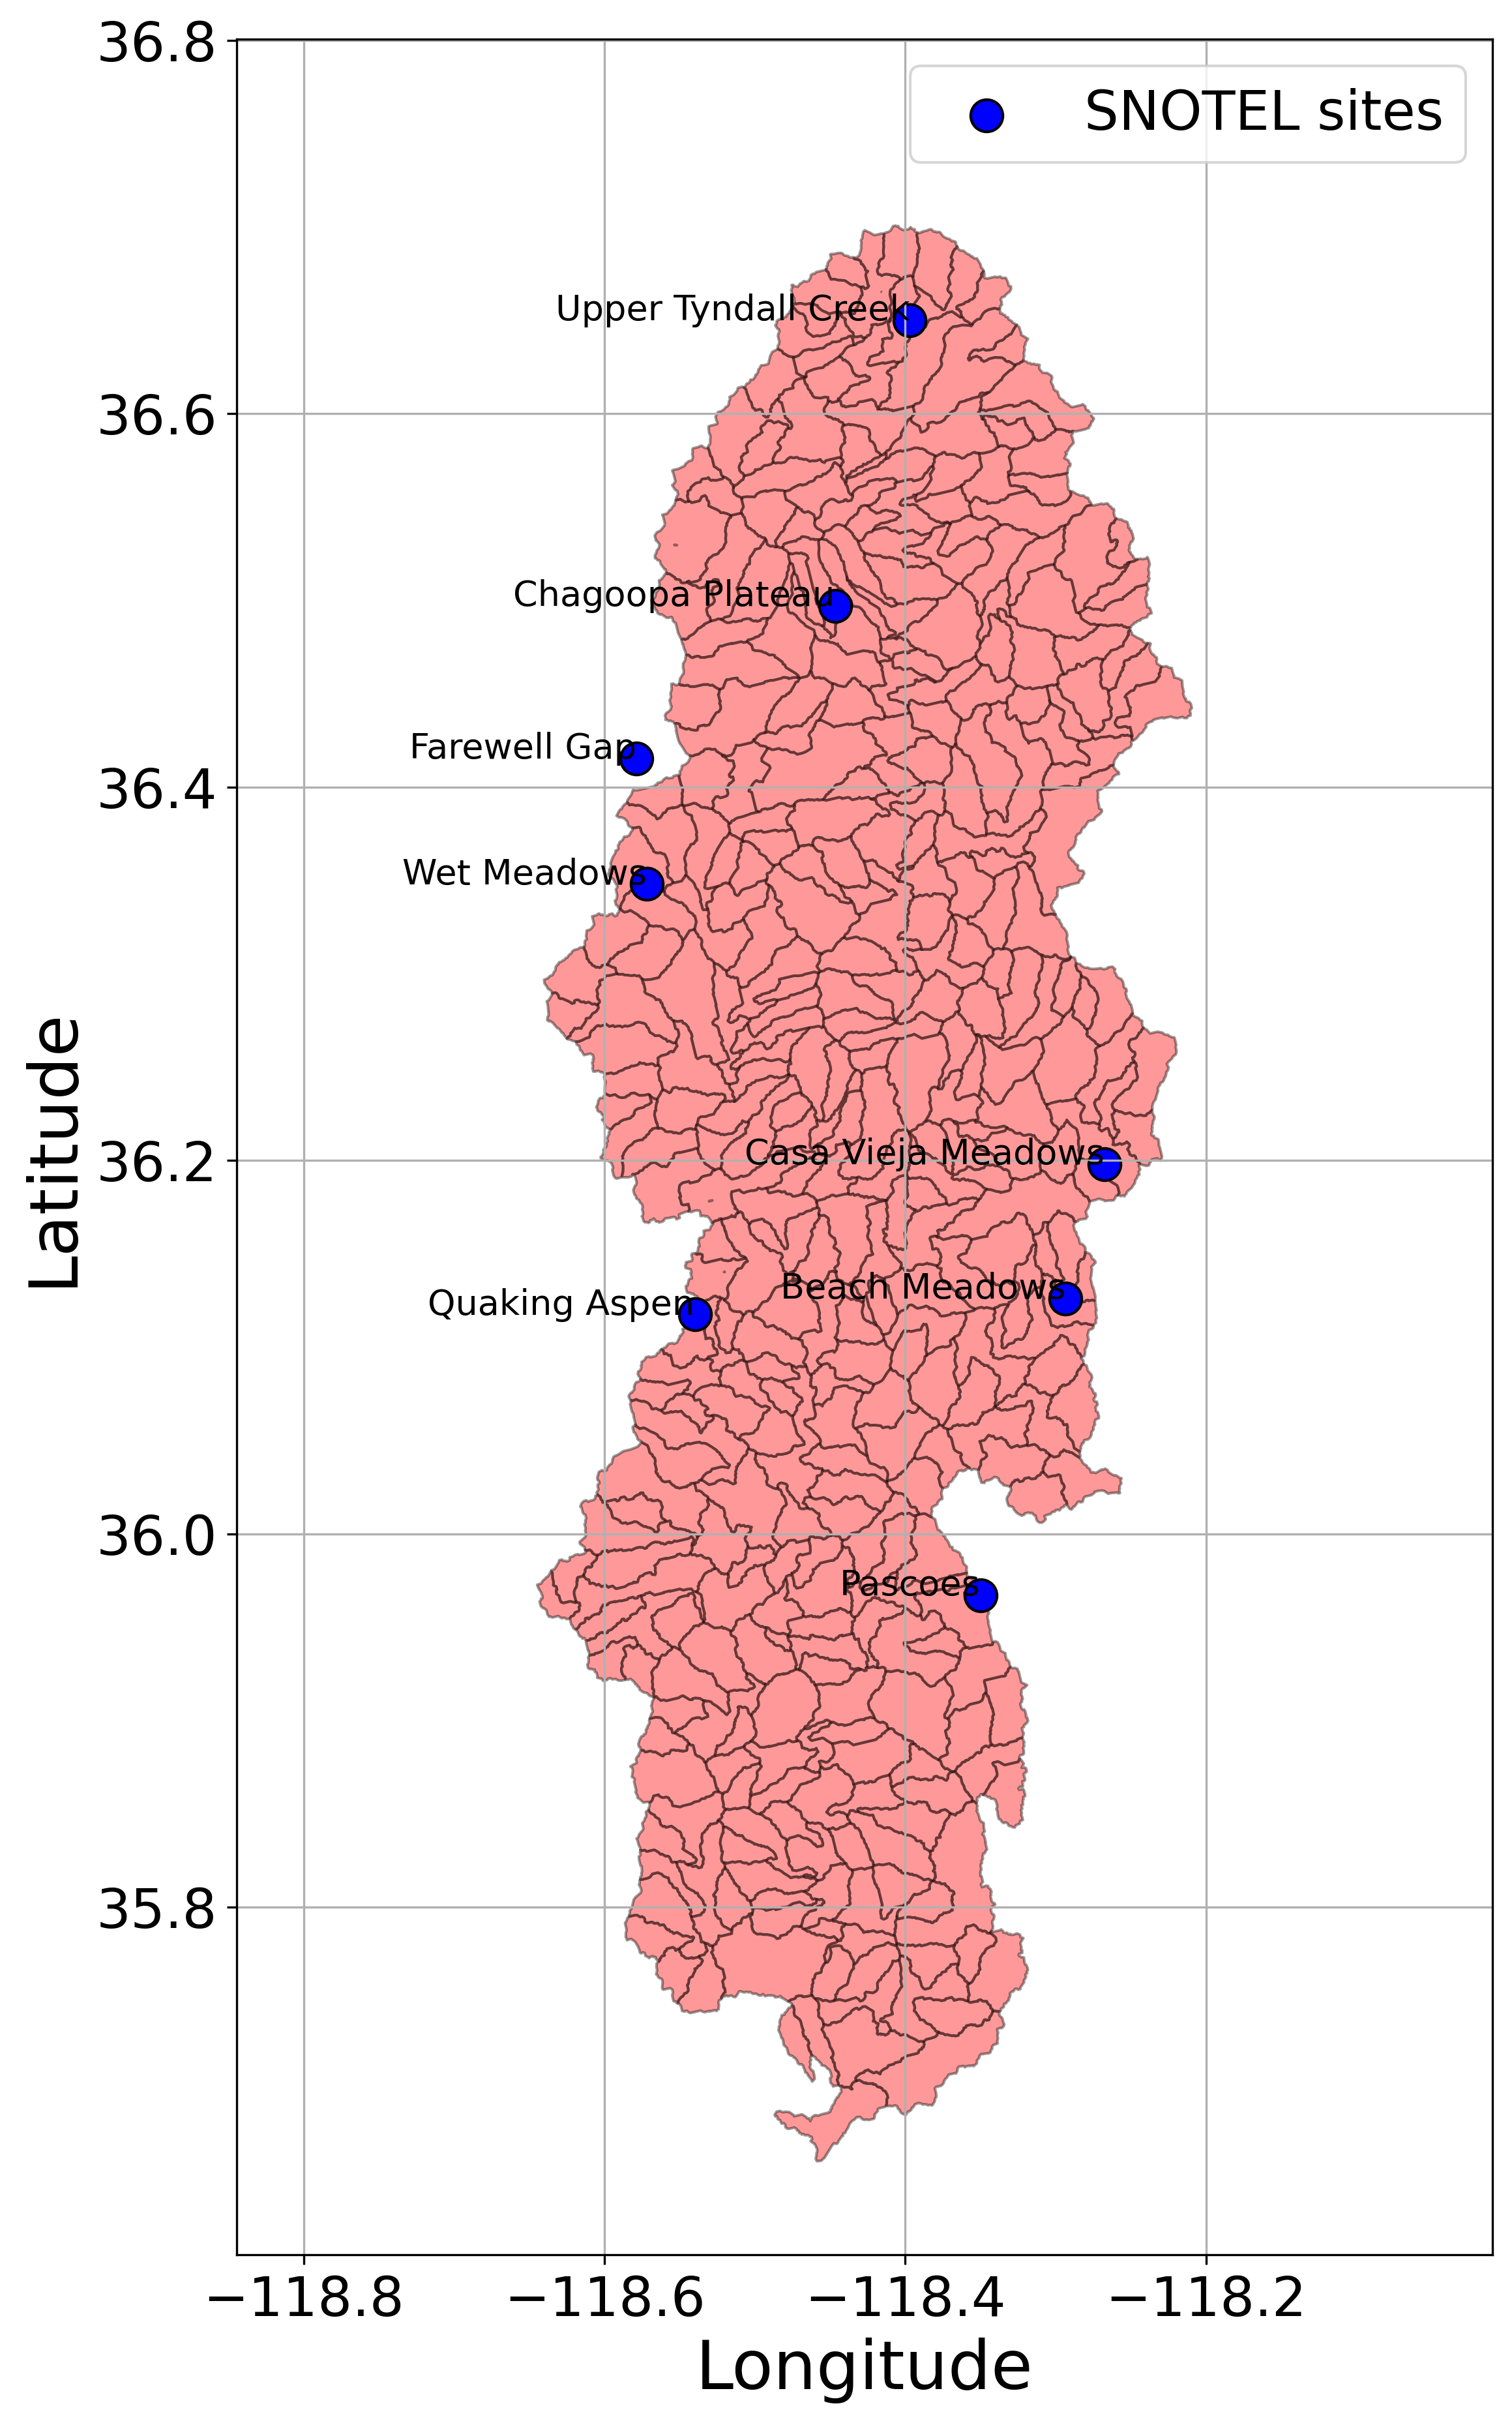

In [16]:
# Paths to your files
catchment_file = 'catchments.geojson'
SnowTel_file = 'SNOTEL.geojson'

# Read the GeoJSON files into GeoDataFrames
gdf_catchment = gpd.read_file(catchment_file)
gdf_SnowTel = gpd.read_file(SnowTel_file)

# Check the CRS of both GeoDataFrames
print("CRS of gdf_catchment:", gdf_catchment.crs)
print("CRS of gdf_SnowTel:", gdf_SnowTel.crs)

# Reproject gdf_gpkg to the CRS of gdf_geojson if they do not match
if gdf_catchment.crs != gdf_SnowTel.crs:
    gdf_catchment = gdf_catchment.to_crs(gdf_SnowTel.crs)

# Create a plot with the first GeoDataFrame (GeoJSON)
fig, ax = plt.subplots(figsize=(15, 15), dpi=300)

# Plot the second GeoDataFrame (GeoPackage) on the same plot
gdf_catchment.plot(ax=ax, color='red', edgecolor='black', alpha=0.4)  
gdf_SnowTel.plot(ax=ax, color='blue', edgecolor='black', alpha=1, markersize=140) 

# Add labels for the points in the GeoJSON file
for x, y, label in zip(gdf_SnowTel.geometry.x, gdf_SnowTel.geometry.y, gdf_SnowTel['name']): 
    ax.text(x, y, label, fontsize=13, ha='right')

# Create custom legend handles
blue_patch = mpatches.Patch(color='blue', label='SNOTEL sites', alpha=1)
red_patch = mpatches.Patch(color='red', label='Case study', alpha=0.3)

# Customize the plot
# ax.set_title('Combined SNOTEL and Catchment Layers', fontsize=25)
ax.set_xlabel('Longitude', fontsize=25)
ax.set_ylabel('Latitude', fontsize=25)

# Add custom legend
# ax.legend(handles=[blue_patch, red_patch], fontsize=20)
ax.legend(['SNOTEL sites'], fontsize=20)

# Add a grid
ax.grid(True)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=20)

# Add a legend
# ax.legend(['Nexes points from hydrofabric subset', 'Snowtel sensor'], loc='upper right', fontsize=15)

# Set axis limits
dd=0.2
ax.set_xlim([min_longitude-dd, max_longitude+dd])
ax.set_ylim([min_latitude-0.05, max_latitude+0.1])


plt.savefig(f'Snotel and Catchment layers.jpg',
            dpi=300,
            bbox_inches= 'tight',  
            pad_inches=0.1,
            transparent= True,
            facecolor= 'White')


# Show the plot
plt.show()



### Plot the SNOTEL sites within the basin using folium library

In [17]:
# Calculate the center of the bounding box
center_lat = (min_latitude + max_latitude) / 2
center_lon = (min_longitude + max_longitude) / 2

# Convert GeoDataFrames to GeoJSON
geojson1 =  SnowTel_file
geojson2 = gdf_catchment.to_json()

# Create a folium map
m = folium.Map([center_lat, center_lon], zoom_start=10)

# Function to apply marker styling
def style_function(feature):
    return {
        'fillColor': 'red',
        'color': 'red',
        'weight': 1,
        'fillOpacity': 1
    }


# Add GeoJSON layers for each GeoDataFrame to the map
folium.GeoJson(
    geojson1,
    name='Snotel sites',
    zoom_on_click=True,
    style_function=style_function,
    marker=folium.Marker(icon=folium.Icon(color='red'))
).add_to(m)

folium.GeoJson(geojson2, name='GeoDataFrame 2').add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Display the map
m

### Retrieve SNOTEL data for the selected sites

In [19]:
SnowTel.reset_index(inplace=True)
SnowTel

,index,station_id,name,elevation_m,latitude,longitude,state,geometry
0,4,CDEC:BCH,Beach Meadows,2331.72,36.126095,-118.293457,California,POINT (-118.29346 36.12609)
1,19,CDEC:CHP,Chagoopa Plateau,3139.44,36.497143,-118.446716,California,POINT (-118.44672 36.49714)
2,22,CDEC:CSV,Casa Vieja Meadows,2529.84,36.198097,-118.267685,California,POINT (-118.26769 36.19810)
3,35,CDEC:FRW,Farewell Gap,2895.60,36.415211,-118.578979,California,POINT (-118.57898 36.41521)
4,70,CDEC:PSC,Pascoes,2788.92,35.966999,-118.349998,California,POINT (-118.35000 35.96700)
5,72,CDEC:QUA,Quaking Aspen,2194.56,36.117508,-118.539993,California,POINT (-118.53999 36.11751)
6,98,CDEC:UTY,Upper Tyndall Creek,3474.72,36.650002,-118.397003,California,POINT (-118.39700 36.65000)
7,104,CDEC:WTM,Wet Meadows,2727.96,36.348000,-118.571999,California,POINT (-118.57200 36.34800)


In [22]:
# start and end times represented as years
StartDate = '2020-10-01'
EndDate = '2023-09-30'

#Define path to output directory
SNOTEL_OutputFolder = './SNOTEL_outputs' 

In [23]:
# Create a folder to save results
isExist = os.path.exists(SNOTEL_OutputFolder)
if isExist == True:
    exit
else:
    os.mkdir(SNOTEL_OutputFolder)

In [26]:
#Define the function to download SNOTEL data 
state_abb= 'CA'

def get_snotel_data(site_name, site_id, state_abb, start_date, end_date, output_folder):
    # Construct the URL
    base_url = 'https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/'
    url = f'{base_url}{site_id}:{state_abb}:MSNT%257Cid=%2522%2522%257Cname/{start_date},{end_date}/WTEQ::value,WTEQ::median_1991,PREC::value,PREC::median_1991?fitToScreen=false'
    
    print(f'Retrieving data for {site_name}, {site_id}')
    print(f'URL: {url}')
    
    # Make the HTTP request
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f'Failed to retrieve data: {response.status_code}')
        return

    # Decode the response content
    data = response.content.decode('utf-8')
    
    # Split the data into lines and remove header lines
    lines = data.split("\n")
    lines = [line for line in lines if not line.startswith("#") and line]
    
    if not lines:
        print(f'No data retrieved for {site_name}')
        return
    
    # Convert the lines into a DataFrame
    df = pd.DataFrame([line.split(',') for line in lines])
    
    # Rename columns based on the first row
    df.columns = df.iloc[0]
    df = df[1:]
    
    # Reset index
    df.reset_index(drop=True, inplace=True)
    
    # Ensure 'Date' column exists and convert it to datetime
    if 'Date' in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
    else:
        print("The 'Date' column is not present in the data.")
        return
    
    # Rename columns for clarity
    df.rename(columns={df.columns[1]: 'Snow Water Equivalent (m) Start of Day Values'}, inplace=True)
    df.rename(columns={df.columns[2]: 'Median Snow Water Equivalent (1991-2020) (m) Start of Day Values'}, inplace=True)
    df.rename(columns={df.columns[3]: 'Precipitation Accumulation (1991-2020) (m) Start of Day Values'}, inplace=True)
    df.rename(columns={df.columns[4]: 'Median Precipitation Accumulation (1991-2020) (m) Start of Day Values'}, inplace=True)
    
    
    # Convert Snow Water Equivalent values to meters
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce') * 0.0254  # convert inches to meters
    
    # Add Water Year column
    df['Water_Year'] = df['Date'].apply(lambda x: x.year + 1 if x.month > 9 else x.year)
    

    # Save the DataFrame to a CSV file
    output_file_path = os.path.join(output_folder, f'{site_id}_{site_name}_SNTL.csv')
    df.to_csv(output_file_path, index=False)
    print(f'Data for {site_name} saved to {output_file_path}')

if __name__ == "__main__":

    # Retrieve data for each station
    for i in SnowTel.index:
        site_name = SnowTel["name"][i]
        station_id = SnowTel["station_id"][i]
        station_id_part1, station_id_part2 = station_id.split(':')
        
        get_snotel_data(site_name, station_id_part2, state_abb, StartDate, EndDate, SNOTEL_OutputFolder)


Retrieving data for Beach Meadows, BCH
URL: https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/BCH:CA:MSNT%257Cid=%2522%2522%257Cname/2020-10-01,2023-09-30/WTEQ::value,WTEQ::median_1991,PREC::value,PREC::median_1991?fitToScreen=false
Data for Beach Meadows saved to ./SNOTEL_outputs\BCH_Beach Meadows_SNTL.csv
Retrieving data for Chagoopa Plateau, CHP
URL: https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/CHP:CA:MSNT%257Cid=%2522%2522%257Cname/2020-10-01,2023-09-30/WTEQ::value,WTEQ::median_1991,PREC::value,PREC::median_1991?fitToScreen=false
Data for Chagoopa Plateau saved to ./SNOTEL_outputs\CHP_Chagoopa Plateau_SNTL.csv
Retrieving data for Casa Vieja Meadows, CSV
URL: https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/CSV:CA:MSNT%257Cid=%2522%2522%257Cname/2020-10-01,2023-09-30/WTEQ::val